# Resumo deste notebook

### **TP1 ML - Alexandre Gomes Caldeira - 2024666544**

Abaixo apresento minha solução ao Trabalho Prático 1 da disciplina DIP DCC831 PG3 - Tópicos Especiais em Ciência da Computação - Aprendizado de Máquina. Nessa seção é dado um resumo dos métodos e resultados obtidos como resposta aos requisitos do trabalho, cuja implementação pode ser vista em detalhes nas seções seguintes.

Está disponível também um [Repositório Github](https://github.com/Alexandre-Caldeira/tp1_ml_mnist) ([github.com/Alexandre-Caldeira/tp1_ml_mnist](https://github.com/Alexandre-Caldeira/tp1_ml_mnist)) com histórico de implementação e resultados parciais. O repositório inclui requisitos para o ambiente de execução deste notebook para replicação dos resultados. Vale dizer que a execução dos resultados é demorada: 18hrs em CPU i7-8565U, 16 GB RAM.

Método:
- Aplicada validação cruzada com 5 *folds* (StratifiedKFold) em redes neuronais com regularização por decaimento de peso ajustado de maneira automatizada
- Cada modelo teve taxa de aprendizado: 0.5, 1 e 10; neurônios na camada oculta: 25, 50 e 100; número de exemplos para cálculo de gradiente: 1 (SGD), 10 (mini-batch SGD), 50 (mini-batch SGD) e 3350 (todos os dados, GD);
- O resultado de validação cruzada dos modelos regularizados é comparado, esperando-se observar e ilustrar o ["*bias-variance trade-off*"](https://arxiv.org/abs/1812.11118).

Principais Resultados:
1. Taxa de Aprendizado menor atinge performances melhores
2. Mais exemplos para cada cálculo de gradiente resulta em performances melhores
3. Mais neurônios na camada oculta não necessariamente melhora os resultados, parece haver um limite
4. Mais neurônios na camada oculta performam melhor com taxas menores de aprendizado

Disclaimer:
- É válido aumentar o número de *folds*, variações de regularização e épocas para otimizar os resultados quantitativamente (nota final máxima de Acurácia e F1-score). Qualitativamente, nenhuma mudança será observada.

## **Pacotes utilizados**


Alguns pacotes (bibliotecas Python) foram utilizadas para:
- **Implementação da rede neuronal, descida gradiente (estocástica)** ([PyTorch](https://pytorch.org/))
- **Manipulação e visualização dos dados** ([Pandas](https://pandas.pydata.org/), [Numpy](https://numpy.org/), [Matplotlib](https://matplotlib.org/))
- **Separação de dados, implementação de métricas e validação cruzada** ([Scikit-learn](https://scikit-learn.org/))
- **Otimização automatizada do hiperparametro de regularização L2** ([Optuna](https://optuna.org/))
- **Registro de resultados e parâmetros de cada modelo durante e ao fim do treino** ([MLflow](https://mlflow.org/))

## **Sumário de resultados**

### **Método**:

1. usando uma rede com 784 neurônios na camada de entrada (uma para pixel da imagem de entrada) e 10 neurônios na camada de saída, foram treinadas redes com 25, 50 e 100 neurônios na camada oculta com ativação sigmóide.
2. O treino se deu por descida gradiente (clássica, estocástica e mini-batch com batches de 10 e 50 exemplos), usando como função de custo a entropia cruzada, utilizando taxa de aprendizado 0.5, 1 e 10.
3. Foi aplicada regularização por decaimento de pesos (teoria: [Weight Decay](https://paperswithcode.com/method/weight-decay), implementação: [PyTorch Stochastic Gradient Descent with Weight Decay](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) cujo peso $\lambda$ foi otimizado automaticamente com Optuna em 5 tentativas.
4. O treino foi conduzido empregando validação cruzada de modelos treinados independentemente em 5 amostras aleatórias diferentes do dataset original, separando 67% dos dados para treino (3350 exemplos) e 33% dos dados para teste (1650 exemplos), utilizando a estratégia de [StratifiedKFold (Scikit-learn)](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) para k = 5 com embaralhamento (shuffling).
5. Cada treino em cada *fold* teve seus parâmetros registrados via MLflow (lr - *taxa de aprendizado*, hidden_dim - *tamanho da camada oculta*, batch_size - *número de exemplos por batch de treino* e weight decay - *decaimento de pesos*), assim como as métricas durante o treinamento (valor da função de custo em treino e teste, [accuracy e F1-score](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)) e fora do treinamento (valor médio de acurácia e F1-score nos *folds*, certificado por validação cruzada).


### **Principais Resultados**: Taxa de Aprendizado menor atinge performances melhores

![](imgs/lr_cv.jpg)

### **Principais Resultados**: Mais exemplos para cada cálculo de gradiente resulta em performances melhores

![](imgs/batch_size_cv.jpg)

### **Principais Resultados**: Mais neurônios na camada oculta não necessariamente melhora os resultados, parece haver um limite


![](imgs/hidden_dim_cv.jpg)


### **Principais Resultados**: Mais neurônios na camada oculta performam melhor com taxas menores de aprendizado

![](imgs/f1cv_hidden_dim_lr.jpg)

![](imgs/acccv_hidden_dim_lr.jpg)


### **Disclaimers**

Um número maior de épocas de treino e de tentativas (trials) de otimização de regularização Optuna poderiam aumentar a Acurácia e F1-score final dos modelos em geral, assim como um k maior de folds de validação cruzada poderia aumentar a confiabilidade do resultado final. Porém, devido à restrição de tempo (deadline de entrega do trabalho) optou-se por 50 épocas, 5 tentativas de otimização e 5 separações de dados para validação cruzada. Ainda assim, os resultados condizem com o esperado mediante teoria, e seguem as melhores práticas.


In [1]:
! pip install optuna

# Carga e Visualização dos Dados

In [2]:
!wget -q https://raw.githubusercontent.com/Alexandre-Caldeira/tp1_ml_mnist/main/data_tp1.csv

[  7   0  84 185 159 151  60  36 222 254 241 198 170  52  67 114  72 163
 227 225 250 229 140  17  66  14  59  21 236 106  83 253 209  18  22 233
 255 129 238  44 249  62 133 187   5   9 205 248  58 126 182  75 251 240
  57  19 221 166   3 203 219  35  38  77  31 224 115   1  61 242 121  40
 207]


,y,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


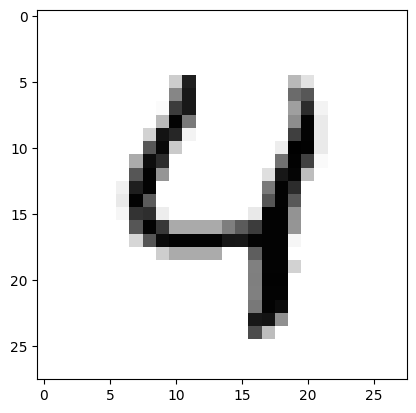

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

data = pd.read_csv('/content/data_tp1.csv',header=None)
data = data.rename(columns={0:'y'})
print(data.iloc[0,:].unique())

imsize = round(np.sqrt(784)+1)
linha_y = 4
img = np.reshape(data.iloc[linha_y,1:].values, (imsize-1,imsize-1))
plt.imshow(255-img,cmap='gray')

data.head(2)

# Definição do formato do modelo e dos dados

In [4]:
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split

y = data.y.values
X = data.drop(columns='y').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(y_train.shape)
idx = 0
print((X_train[idx,:]).shape)
print(y_train[idx])
(y_train[idx]).shape

# Pytorch exige que seja utilizado um dataset por algum motivo aparentemente
class custom_mnist_dataset():
    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Restrições de uso do pytorch: (leia os docs...)
        # inputs tem que ser float para multiplicar pelos pesos,
        # outputs tem que ser longint para calcular crossentropy
        return torch.tensor(self.X[idx,:], dtype=torch.float), self.y[idx]

training_data = custom_mnist_dataset(X = X_train, y = y_train)
test_data = custom_mnist_dataset(X = X_test, y = y_test)

# batch_size de exemplo para teste
batch_size = 25

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape, type: X: {X.shape} {X.dtype}")
    print(f"Shape, type: y: {y.shape} {y.dtype}")
    break


(3350, 784)
(3350,)
(784,)
7
Shape, type: X: torch.Size([25, 784]) torch.float32
Shape, type: y: torch.Size([25]) torch.int64


In [5]:
# Get cpu, gpu or mps device for training.
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
!pip install cloud-tpu-client==0.10
# https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch-xla-2.0-cp39-cp39-linux_x86_64.whl

In [9]:
# Create a tensor on the TPU
import torch_xla.core.xla_model as xm

dev = xm.xla_device()  # Acquires the first TPU core
tensor_on_tpu = torch.tensor([1.0], device=dev)
print(tensor_on_tpu)

tensor([1.], device='xla:0')


In [10]:
from torch import nn
import torch.nn.functional as F

"""
NeuralNetwork tem 3 camadas, com ativação sigmóide na camada oculta cujo tamanho será ajustado.
"""
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(NeuralNetwork, self).__init__()

        self.entrada = nn.Linear(input_size, hidden_dim)
        self.oculta = nn.Linear(hidden_dim, hidden_dim)
        self.saida = nn.Linear(hidden_dim, output_size)

    def forward(self, input):

        x1 = self.entrada(input)
        x2 = F.sigmoid(self.oculta(x1))
        x3 = self.saida(x2)

        return x3

# Exemplo hidden dim = 25
print(NeuralNetwork(input_size = X_train.shape[1], hidden_dim= 25, output_size=10).to(device))


NeuralNetwork(
  (entrada): Linear(in_features=784, out_features=25, bias=True)
  (oculta): Linear(in_features=25, out_features=25, bias=True)
  (saida): Linear(in_features=25, out_features=10, bias=True)
)


# Definição dos passos de treino e teste

In [11]:
# Referência utilizada e adaptada:
# https://www.kaggle.com/code/shrutimechlearn/pytorch-custom-model-step-by-step

def train_step(model, loss_func, optimizer, dataloader):

    # to capture loss
    train_loss = 0

    # to get the model in training mode
    model.train()

    for batch, (x_batch, y_batch) in enumerate(dataloader):
        # sending data to the device where rest of the artifacts are
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # forward pass/model prediction with the given input
        y_pred = model(x_batch)

        # loss calculation by comparison between predicted and ground truth values
        loss = loss_func(y_pred, y_batch)
        train_loss += loss.item()

        # setting previously collected gradient values in the optimizer to zero so it translates only current gradients
        optimizer.zero_grad()

        # calculate the gradients for this iteration (independent gradients because previous values have been reset to 0)
        loss.backward()

        # update the weights and biases based on the calculated gradients ~(wi = wi + delta_wi)
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)

    return train_loss

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_step(model, loss_func, test_dataloader):

    test_loss = 0

    model.eval()
    total_preds = []
    total_labels = []

    with torch.inference_mode():

        for batch, (x_batch, y_batch) in enumerate(test_dataloader):

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)

            loss = loss_func(y_pred, y_batch)
            test_loss+= loss.item()

            _, preds = torch.max(y_pred, dim=1)
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(y_batch.cpu().numpy())

    test_loss = test_loss/len(test_dataloader)

    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
    recall = recall_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
    f1 = f1_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))

    return accuracy, precision, recall, f1, test_loss


In [13]:
# import mlflow

def train_and_evaluate_model(model, loss_func, optimizer, train_dataloader, val_dataloader, n_epochs, lr, hds, bs,weight_decay,i):
  # with mlflow.start_run(run_name=f"Test  #{i}", nested = True):  # Name each run based on the learning rate
  #     mlflow.log_param("weight_decay", weight_decay)
  #     mlflow.log_param("batch_size", bs)
  #     mlflow.log_param("hidden_dim", hds)
  #     mlflow.log_param("lr", lr)

      model.train()  # Set the model to training mode
      train_losses = []
      val_losses = []
      accuracies = []
      f1_scores = []

      train_loss = []
      test_loss = []

      for epoch in range(n_epochs):

          tr_loss = train_step(model, loss_func, optimizer, train_dataloader)

          accuracy, precision, recall, f1, ts_loss = test_step(model, loss_func, test_dataloader)

          test_loss.append(ts_loss)
          train_losses.append(tr_loss)
          accuracies.append(accuracy)
          f1_scores.append(f1)

          # mlflow.log_metric("loss", tr_loss, step = epoch)
          # mlflow.log_metric("val_loss", ts_loss, step = epoch)
          # mlflow.log_metric("diff_loss_tr_ts", tr_loss-ts_loss, step = epoch)

          # mlflow.log_metric("accuracy", accuracy, step = epoch)
          # mlflow.log_metric("precision", precision, step = epoch)
          # mlflow.log_metric("recall", recall, step = epoch)
          # mlflow.log_metric("f1", f1, step = epoch)
          return train_losses, val_losses, accuracies, f1_scores

# Definição dos testes automatizados e registro de dados em MLflow

In [14]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from torch import nn
from datetime import datetime

def objective(trial, lr, hds, bs, X_train, y_train,n_epochs,n_splits):

    # Suggest regularization parameter using the trial object
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 0.1, log = True)

    text = "Experiment - lr({lr}) hds({hds}) bs({bs}) wd({wd})".format(lr =lr,hds=hds,bs =bs,wd = weight_decay)
    # with mlflow.start_run(run_name=text, experiment_id = experiment_id):

    # Initialize the model with fixed hyperparameters and suggested regularization
    model = NeuralNetwork(input_size=X_train.shape[1], hidden_dim=hds, output_size=10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func = nn.CrossEntropyLoss()

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {"accuracy": [], "f1": []}
    fold = 1

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        train_dataloader_fold = DataLoader(custom_mnist_dataset(X=X_train_fold, y=y_train_fold), batch_size=bs)
        val_dataloader_fold = DataLoader(custom_mnist_dataset(X=X_val_fold, y=y_val_fold), batch_size=bs)

        # Train and evaluate the model for this fold
        train_loss, test_loss, accuracy, f1 = train_and_evaluate_model(
            model, loss_func, optimizer, train_dataloader_fold, val_dataloader_fold, n_epochs=n_epochs,
            lr=lr, hds=hds, bs=bs, weight_decay = weight_decay, i=fold)

        fold = fold+1

        # Calculate average scores across all folds
        cv_scores["accuracy"].append(accuracy)
        cv_scores["f1"].append(f1)

    # Return the average cross-validated scores
    # mlflow.log_param("weight_decay", weight_decay)
    # mlflow.log_param("batch_size", bs)
    # mlflow.log_param("hidden_dim", hds)
    # mlflow.log_param("lr", lr)
    # mlflow.log_metric("cv-accuracy", np.mean(cv_scores["accuracy"]))
    # mlflow.log_metric("cv-f1",  np.mean(cv_scores["f1"]))

    return np.mean(cv_scores["accuracy"]), np.mean(cv_scores["f1"])

In [15]:

# Fixed hyperparameters
fixed_hyperparams = {
    'learning_rates': [0.5, 1, 10],
    'hidden_dim_sizes': [25, 50, 100],
    'batch_sizes': [1, 10, 50, len(training_data)],
}

# watch out for n_trials, n_splits, n_epochs
n_trials = 5
n_splits = 5
n_epochs = 200

# Set up MLflow tracking URI
# mlflow.set_tracking_uri('http://localhost:5000')
# mlflow.autolog()

# Get the current date and time
now = datetime.now()

# Convert to string in the format 'YYYY-MM-DD HH:MM:SS'
formatted_now = now.strftime('%Y%m%dT%H%M%S')
print(formatted_now)

# mlflow_exp = mlflow.set_experiment(experiment_name  = 'TP1ML - '+formatted_now)

# Iterate over fixed hyperparameters
best_results = {}
for lr in fixed_hyperparams['learning_rates']:
    for hds in fixed_hyperparams['hidden_dim_sizes']:
        for bs in fixed_hyperparams['batch_sizes']:
            # Create an Optuna study for each combination
            study_name =  "Study - lr({lr}) hds({hds}) bs({bs}) - ".format(lr =lr,hds=hds,bs =bs)+formatted_now
            study = optuna.create_study(directions=["maximize", "maximize"],study_name =study_name )

            study.optimize(
                lambda t: objective(t, lr, hds, bs, X_train, y_train,n_epochs,n_splits)
                , n_trials=n_trials
                )

            # Record the best trial
            best_trial = study.best_trials[0]
            best_accuracy = best_trial.values[0]
            best_f1 = best_trial.values[1]

            # Record best results
            best_results[(lr, hds, bs)] = {
                'best_accuracy': best_accuracy,
                'best_f1': best_f1,
            }

        print(best_results[(lr, hds, bs)])

[I 2024-06-16 20:39:20,862] A new study created in memory with name: Study - lr(0.5) hds(25) bs(1) - 20240616T203920


20240616T203920


[I 2024-06-16 20:39:33,326] Trial 0 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.04118720763677767}. 
[I 2024-06-16 20:39:44,570] Trial 1 finished with values: [0.11357575757575758, 0.2032094316768569] and parameters: {'weight_decay': 0.001047307946677191}. 
[I 2024-06-16 20:39:55,880] Trial 2 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 2.2383813547764494e-05}. 
[I 2024-06-16 20:40:07,255] Trial 3 finished with values: [0.11090909090909089, 0.19829299459692082] and parameters: {'weight_decay': 2.4547932703375272e-05}. 
[I 2024-06-16 20:40:18,377] Trial 4 finished with values: [0.17733333333333332, 0.3422086503114452] and parameters: {'weight_decay': 0.0005101434871848564}. 
[I 2024-06-16 20:40:18,379] A new study created in memory with name: Study - lr(0.5) hds(25) bs(10) - 20240616T203920
[I 2024-06-16 20:40:20,562] Trial 0 finished with values: [0.13272727272727275, 0.3025342933

{'best_accuracy': 0.3290909090909091, 'best_f1': 0.2841431795781334}


[I 2024-06-16 20:41:34,029] Trial 0 finished with values: [0.1755151515151515, 0.35867673837774666] and parameters: {'weight_decay': 0.0002934574421012424}. 
[I 2024-06-16 20:42:31,743] Trial 1 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.00259986338039226}. 
[I 2024-06-16 20:43:28,935] Trial 2 finished with values: [0.10315151515151515, 0.19211290347200755] and parameters: {'weight_decay': 0.016816111217059847}. 
[I 2024-06-16 20:44:25,469] Trial 3 finished with values: [0.10024242424242424, 0.16356376945132206] and parameters: {'weight_decay': 0.0003051996091077172}. 
[I 2024-06-16 20:45:21,970] Trial 4 finished with values: [0.1189090909090909, 0.19262915780928563] and parameters: {'weight_decay': 0.002198576153963446}. 
[I 2024-06-16 20:45:21,973] A new study created in memory with name: Study - lr(0.5) hds(50) bs(10) - 20240616T203920
[I 2024-06-16 20:45:24,161] Trial 0 finished with values: [0.15757575757575756, 0.370924277442

{'best_accuracy': 0.3808484848484849, 'best_f1': 0.3345312636103176}


[I 2024-06-16 20:46:25,804] Trial 0 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.09306156844568043}. 
[I 2024-06-16 20:47:09,441] Trial 1 finished with values: [0.17163636363636364, 0.21063575702921492] and parameters: {'weight_decay': 0.00014845970782264708}. 
[I 2024-06-16 20:47:52,943] Trial 2 finished with values: [0.1373333333333333, 0.2369862149568688] and parameters: {'weight_decay': 0.0018966326608392473}. 
[I 2024-06-16 20:48:36,960] Trial 3 finished with values: [0.10836363636363636, 0.1680913969292584] and parameters: {'weight_decay': 0.006767012164151339}. 
[I 2024-06-16 20:49:20,720] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.009879658245829644}. 
[I 2024-06-16 20:49:20,723] A new study created in memory with name: Study - lr(0.5) hds(100) bs(10) - 20240616T203920
[I 2024-06-16 20:49:23,112] Trial 0 finished with values: [0.1484848484848485, 0.2213968444248

{'best_accuracy': 0.36024242424242425, 'best_f1': 0.4228829491202819}


[I 2024-06-16 20:49:50,861] Trial 0 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0007783160715267844}. 
[I 2024-06-16 20:50:02,054] Trial 1 finished with values: [0.10036363636363636, 0.16428270096596367] and parameters: {'weight_decay': 0.0024658551956474465}. 
[I 2024-06-16 20:50:12,735] Trial 2 finished with values: [0.14096969696969697, 0.25612751387666666] and parameters: {'weight_decay': 0.0017574742397159734}. 
[I 2024-06-16 20:50:25,003] Trial 3 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.03879824652651449}. 
[I 2024-06-16 20:50:37,052] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.01414940309104428}. 
[I 2024-06-16 20:50:37,054] A new study created in memory with name: Study - lr(1) hds(25) bs(10) - 20240616T203920
[I 2024-06-16 20:50:39,130] Trial 0 finished with values: [0.09806060606060607, 0.17856367743898

{'best_accuracy': 0.3363636363636363, 'best_f1': 0.31777826904407713}


[I 2024-06-16 20:51:51,132] Trial 0 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.007143889315278183}. 
[I 2024-06-16 20:52:47,399] Trial 1 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0006151487905519281}. 
[I 2024-06-16 20:53:44,210] Trial 2 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.00037322893171288824}. 
[I 2024-06-16 20:54:40,493] Trial 3 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0050414410212984585}. 
[I 2024-06-16 20:55:37,107] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.008301427772854308}. 
[I 2024-06-16 20:55:37,109] A new study created in memory with name: Study - lr(1) hds(50) bs(10) - 20240616T203920
[I 2024-06-16 20:55:39,171] Trial 0 finished with values: [0.10145454545454546, 0.1474498850366

{'best_accuracy': 0.2767272727272727, 'best_f1': 0.3192395391359136}


[I 2024-06-16 20:56:37,993] Trial 0 finished with values: [0.13187878787878787, 0.21388657083687918] and parameters: {'weight_decay': 0.0008997542737816497}. 
[I 2024-06-16 20:57:22,856] Trial 1 finished with values: [0.10036363636363636, 0.16633283072834806] and parameters: {'weight_decay': 0.03577368876333392}. 
[I 2024-06-16 20:58:06,402] Trial 2 finished with values: [0.1441212121212121, 0.14611148424487902] and parameters: {'weight_decay': 2.9206778470000574e-05}. 
[I 2024-06-16 20:58:51,220] Trial 3 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.06329005637469934}. 
[I 2024-06-16 20:59:35,431] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.014099546621835284}. 
[I 2024-06-16 20:59:35,434] A new study created in memory with name: Study - lr(1) hds(100) bs(10) - 20240616T203920
[I 2024-06-16 20:59:37,827] Trial 0 finished with values: [0.1092121212121212, 0.18735766292561

{'best_accuracy': 0.1915151515151515, 'best_f1': 0.2825529021790057}


[I 2024-06-16 21:00:04,836] Trial 0 finished with values: [0.1421818181818182, 0.24303666662373002] and parameters: {'weight_decay': 5.5223639061066696e-05}. 
[I 2024-06-16 21:00:16,419] Trial 1 finished with values: [0.11515151515151516, 0.24818099002977628] and parameters: {'weight_decay': 5.253636123432095e-05}. 
[I 2024-06-16 21:00:27,568] Trial 2 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0011202980680410876}. 
[I 2024-06-16 21:00:38,557] Trial 3 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 6.020171164163256e-05}. 
[I 2024-06-16 21:00:49,839] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 1.1227809764933217e-05}. 
[I 2024-06-16 21:00:49,841] A new study created in memory with name: Study - lr(10) hds(25) bs(10) - 20240616T203920
[I 2024-06-16 21:00:51,956] Trial 0 finished with values: [0.10036363636363636, 0.18238939

{'best_accuracy': 0.1267878787878788, 'best_f1': 0.21640845702377787}


[I 2024-06-16 21:02:04,027] Trial 0 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 8.993011040890976e-05}. 
[I 2024-06-16 21:03:01,548] Trial 1 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.009255569039695662}. 
[I 2024-06-16 21:03:58,564] Trial 2 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0019943619040779306}. 
[I 2024-06-16 21:04:55,169] Trial 3 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0004951765395472209}. 
[I 2024-06-16 21:05:52,697] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.02518895990090152}. 
[I 2024-06-16 21:05:52,699] A new study created in memory with name: Study - lr(10) hds(50) bs(10) - 20240616T203920
[I 2024-06-16 21:05:54,861] Trial 0 finished with values: [0.09915151515151514, 0.18038523119441

{'best_accuracy': 0.11939393939393939, 'best_f1': 0.2057273778989102}


[I 2024-06-16 21:06:54,135] Trial 0 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 1.6800364766707536e-05}. 
[I 2024-06-16 21:07:38,515] Trial 1 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0014677286130788142}. 
[I 2024-06-16 21:08:22,305] Trial 2 finished with values: [0.13999999999999999, 0.27437315401198087] and parameters: {'weight_decay': 2.54724312143975e-05}. 
[I 2024-06-16 21:09:07,261] Trial 3 finished with values: [0.10181818181818181, 0.16536129565410596] and parameters: {'weight_decay': 0.01596245038501966}. 
[I 2024-06-16 21:09:51,734] Trial 4 finished with values: [0.10024242424242424, 0.1821900300334033] and parameters: {'weight_decay': 0.0015909290633794552}. 
[I 2024-06-16 21:09:51,737] A new study created in memory with name: Study - lr(10) hds(100) bs(10) - 20240616T203920
[I 2024-06-16 21:09:54,051] Trial 0 finished with values: [0.10254545454545454, 0.1769213977

{'best_accuracy': 0.13078787878787876, 'best_f1': 0.2867559973061922}
